In [1]:
import pandas as pd
import json
import pymongo
import matplotlib.dates as mdates
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cache_magic
from datetime import timedelta

pd.options.mode.chained_assignment = None

%cache magic is now registered in ipython


In [2]:
def data_import(include_mums=False):
    """Connects to database and creates dataframe containing all columns. Drops unneeded columns and sets timestamp
     datatype. Correct any incorrect time values, sets data times and sorts"""

    collection_list=['Times']
    
    if include_mums:
        collection_list.append('Mumsnet_Times')
    all_records = []

    # Connects to db and gets collection
    db = get_db()

    for collection in collection_list:
        records =list(db[collection].find())
        all_records.append(records)
    
    #Flattens list
    all_records = [val for sublist in all_records for val in sublist]
    
    df=pd.DataFrame(all_records)
    
    # Makes column to indicate which database times are from
    non_mums = ['Harvey Williams', 'Sazzle', 'Leah', 'Tom', 'Joe', 'George Sheen', 'Oliver Folkard'] 
    df['mum'] = np.where(df['user'].isin(non_mums), False, True)
    
    return df

In [3]:
def get_db(write=False):
    if write:
        connection_string = "admin_connection_string"

    else:
        connection_string = "connection_string"

    try:
        with open("local/pass.json") as file:
            file = json.loads(file.read())
            connection_string = file.get(connection_string)
            client = pymongo.MongoClient(
                connection_string)
            db = client["PlusWord"]
            return db
    except Exception as e:
        print(e)

In [4]:
def format_for_streamlit(df):
    """Makes df more readable, converts times into plottable numbers and sets index"""

    df = df[['load_ts', 'time', 'user']]
    df['time'] = df['time'].str.replace(r'(^\d\d:\d\d$)', r'00:\1', regex=True)
    df['load_ts'] = pd.to_datetime(df['load_ts'], format='%Y-%m-%d %H:%M:%S.%f')
    # df['user'] = df['user'].astype('category')
    df = df.sort_values(by=['load_ts'])
    df = df.rename(columns={'load_ts': 'timestamp'})
    df['time_delta'] = pd.to_timedelta(df['time'].astype('timedelta64[ns]'))
    df['time_delta_as_num'] = time_delta_to_num(pd.to_timedelta(df['time'].astype('string')))
    df['sub_time_delta_as_num'] = time_delta_to_num(pd.to_timedelta(df['timestamp'].dt.time.astype('string')))


    df = df.set_index('timestamp')
    df = df.sort_index(ascending=False)

    return df

In [5]:
def format_for_streamlit(df):
    """Makes df more readable, converts times into plottable numbers and sets index"""

    df = df[['load_ts', 'time', 'user', 'mum']]
    df['time'] = df['time'].str.replace(r'(^\d\d:\d\d$)', r'00:\1', regex=True)
    df['load_ts'] = pd.to_datetime(df['load_ts'], format='%Y-%m-%d %H:%M:%S.%f')
    # df['user'] = df['user'].astype('category')
    df = df.sort_values(by=['load_ts'])
    df = df.rename(columns={'load_ts': 'timestamp'})
    df['time_delta'] = pd.to_timedelta(df['time'].astype('timedelta64[ns]'))
    df['time_delta_as_num'] = time_delta_to_num(pd.to_timedelta(df['time'].astype('string')))
    df['sub_time_delta_as_num'] = time_delta_to_num(pd.to_timedelta(df['timestamp'].dt.time.astype('string')))


    df = df.set_index('timestamp')
    df = df.sort_index(ascending=False)

    return df


In [6]:
def time_delta_to_num(time_delta):
    """ Takes in time delta and converts it into a number for plotting"""

    # specify a date to use for the times

    zero_date = datetime(2022, 6, 20)

    zero_num = mdates.date2num(zero_date)

    # adds zero_data to timedelta to convert

    time_delta_plus_date = [zero_date + time_unit for time_unit in time_delta]

    # convert datetimes to numbers

    time_delta_as_num = [mins - zero_num for mins in mdates.date2num(time_delta_plus_date)]

    return time_delta_as_num

In [7]:
def spline_smooth(df, poly_value):
    """Smooths lines via interpolation and splines. Purely cosmetic"""

    df_spline = df.copy()

    df_spline['date_as_num'] = mdates.date2num(df_spline['timestamp'])

    x_smooth = np.linspace(df_spline['date_as_num'].min(), df_spline['date_as_num'].max(), poly_value)

    bspline = interpolate.make_interp_spline(df_spline['date_as_num'], df_spline['time_delta_as_num'])

    y_smooth = bspline(x_smooth)

    return x_smooth, y_smooth

In [8]:
def savgol_smooth(df, poly_value):
    """Smooths lines using a Savitzky–Golay filter"""

    df_savgol = df.copy()

    df_savgol['date_as_num'] = mdates.date2num(df_savgol['timestamp'])

    max_window = len(df_savgol)

    x_smooth = signal.savgol_filter(df_savgol['date_as_num'], max_window, poly_value)

    y_smooth = signal.savgol_filter(df_savgol['time_delta_as_num'], max_window, poly_value)

    return x_smooth, y_smooth

In [9]:
def y_axis_generator(max_y_value, unit):
    """Creates range for y axis from 0 to max_y_value then passes it to time_delta_to_num. Returns y axis values as
    plottable number"""

    y_axis_time_range = list(range(0, max_y_value, 1))

    y_axis_time_delta = pd.to_timedelta(y_axis_time_range, unit=unit)

    y_axis_time_num = time_delta_to_num(y_axis_time_delta)

    return y_axis_time_num

In [10]:
def time_delta_as_num_to_time(df):
    """Creates a human-readable time from a timedelta and strips the UNIX date from the value to just leave the time"""

    df['Time'] = mdates.num2date(df['time_delta_as_num'])

    df['Time'] = df['Time'].dt.time

    df['Time'] = df['Time'].astype('string')

    df['Time'] = df['Time'].str[:8]

    return df



In [11]:
df = data_import(include_mums=True)
df = format_for_streamlit(df)
window_days=30

,timestamp,user,time_delta,time_delta_as_num,Time
0,2022-06-21 08:45:00,George Sheen,0 days 00:02:41,0.001863,00:02:41
1,2022-06-22 08:48:00,George Sheen,0 days 00:03:56,0.002731,00:03:56
2,2022-06-23 08:41:00,George Sheen,0 days 00:04:18.666667,0.002994,00:04:18
3,2022-06-24 08:38:00,George Sheen,0 days 00:05:32.250000,0.003845,00:05:32
4,2022-06-25 14:07:00,George Sheen,0 days 00:04:46.600000,0.003317,00:04:46
...,...,...,...,...,...
4061,2022-12-14 15:51:00,BrilliantGreenFlamingo,0 days 00:04:23.750000,0.003053,00:04:23
4062,2022-12-15 16:30:00,BrilliantGreenFlamingo,0 days 00:04:17,0.002975,00:04:17
4063,2022-12-01 00:31:00,FaazoHuyzeoSix,0 days 00:01:49,0.001262,00:01:49
4064,2022-12-13 23:19:00,FaazoHuyzeoSix,0 days 00:01:51.500000,0.001291,00:01:51


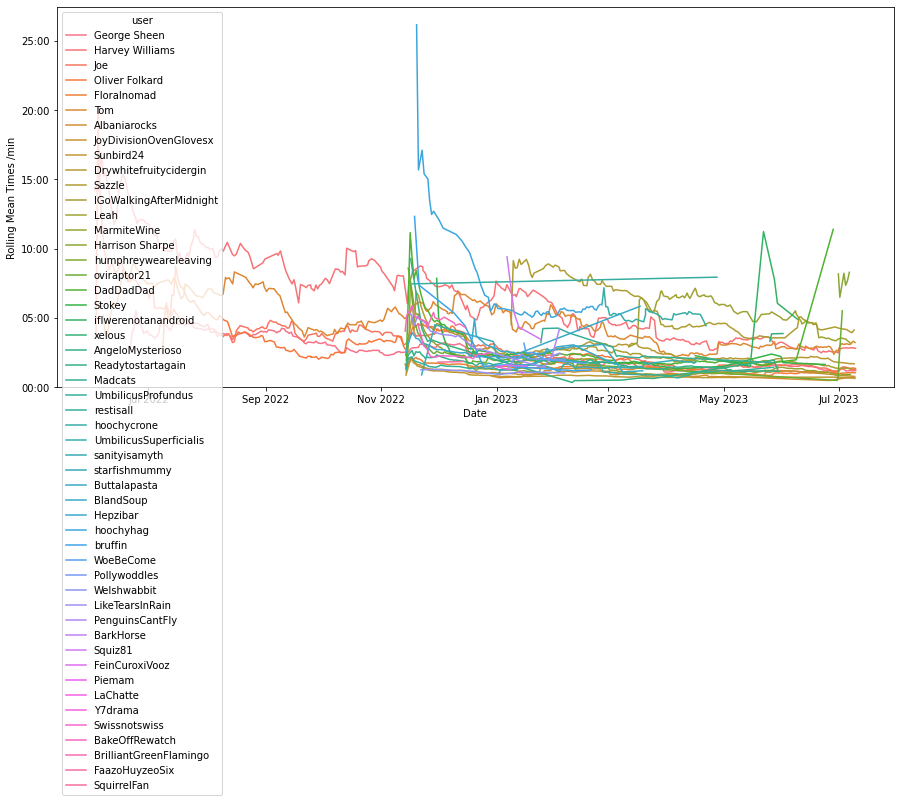

In [12]:
window_days_str = str(window_days) + 'd'

df_ra_list = []

for user in df["user"].unique():
    df_ra = df[df["user"] == user]

    df_ra = df_ra.sort_index()

    #df_ra = df_ra.set_index("timestamp")

    df_ra["time_delta_as_num"] = df_ra["time_delta_as_num"].rolling(window=window_days_str).mean()

    df_ra["time_delta"] = mdates.num2timedelta(df_ra["time_delta_as_num"])

    df_ra = df_ra[['user', 'time_delta', "time_delta_as_num"]]

    df_ra_list.append(df_ra)

    df_ra_finished = pd.concat(df_ra_list)

df_ra_finished = df_ra_finished.reset_index()

fig, ax = plt.subplots(figsize=(15, 7))

fig = sns.lineplot(data=df_ra_finished,
                   x='timestamp',
                   y='time_delta_as_num',
                   hue='user',
                   ).set(
    xlabel='Date',
    ylabel='Rolling Mean Times /min')

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.set_ylim(ymin=0)

df_ra_finished = time_delta_as_num_to_time(df_ra_finished)

df_ra_finished

In [13]:
df_ra_finished['Date'] = df_ra_finished['timestamp'].dt.date

df_ra_finished = df_ra_finished[['user', 'Date', 'Time']]

df_ra_finished = df_ra_finished.rename(columns={'Time': 'Mean Time'})

In [14]:
df_ra_finished

,user,Date,Mean Time
0,George Sheen,2022-06-21,00:02:41
1,George Sheen,2022-06-22,00:03:56
2,George Sheen,2022-06-23,00:04:18
3,George Sheen,2022-06-24,00:05:32
4,George Sheen,2022-06-25,00:04:46
...,...,...,...
4061,BrilliantGreenFlamingo,2022-12-14,00:04:23
4062,BrilliantGreenFlamingo,2022-12-15,00:04:17
4063,FaazoHuyzeoSix,2022-12-01,00:01:49
4064,FaazoHuyzeoSix,2022-12-13,00:01:51
